# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [114]:
!pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable


In [115]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [130]:
con = mysql.connector.connect(user='root', password='**********',
                              host='127.0.0.1',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [117]:
cursor = con.cursor()

sql ="""
SELECT MAX(hire_date), MIN(hire_date) 
FROM employees 
LIMIT 10
"""

cursor.execute(sql)
res = cursor.fetchall()
print(res)



[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]


In [118]:
cursor.close()

True

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [120]:
import pandas as pd

In [121]:
cursor = con.cursor()

sql_1 ="""
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
JOIN(
    SELECT emp_no, MAX(to_date) as max_date
    FROM salaries
    GROUP BY emp_no
) max_dates ON s.emp_no = max_dates.emp_no AND s.to_date = max_dates.max_date

"""
cursor.execute(sql_1)
data = cursor.fetchall()
columns =  [i[0] for i in cursor.description]


res = pd.DataFrame(data, columns=columns)
print(res.head(3))



   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


In [122]:
cursor.close()

True

In [50]:
field_names = [i[0] for i in cursor.description]

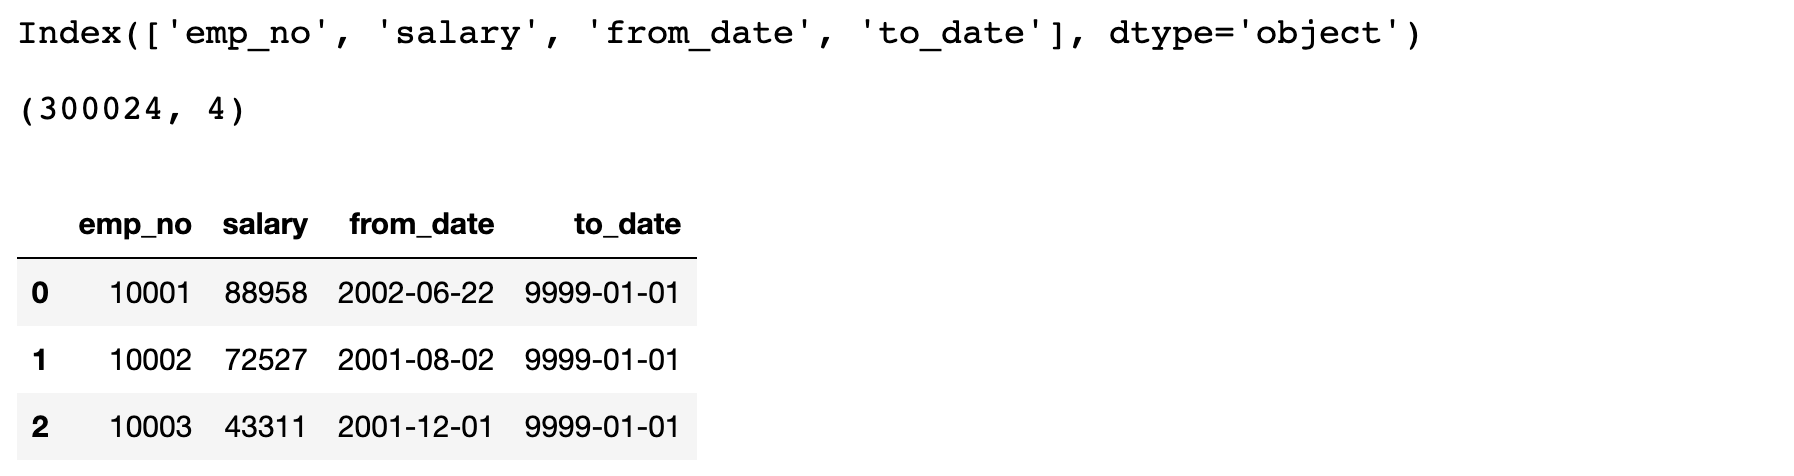

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [ ]:
sql_3 = """

In [124]:
# print(res.dtypes)
print(res.loc[0].to_date)
print(type(res.loc[0].to_date))
still_employed = res.to_date==datetime.date(9999, 1, 1)
not_equal_to_9999 = res.to_date != datetime.date(9999, 1, 1)
count_still_employed = still_employed.sum()
count_not_equal_to_9999 = not_equal_to_9999.sum()

print(f"Кількість значень рівних '9999-01-01': {count_still_employed}")
print(f"Кількість значень НЕ рівних '9999-01-01': {count_not_equal_to_9999}")


9999-01-01
<class 'datetime.date'>
Кількість значень рівних '9999-01-01': 240124
Кількість значень НЕ рівних '9999-01-01': 60056


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [125]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

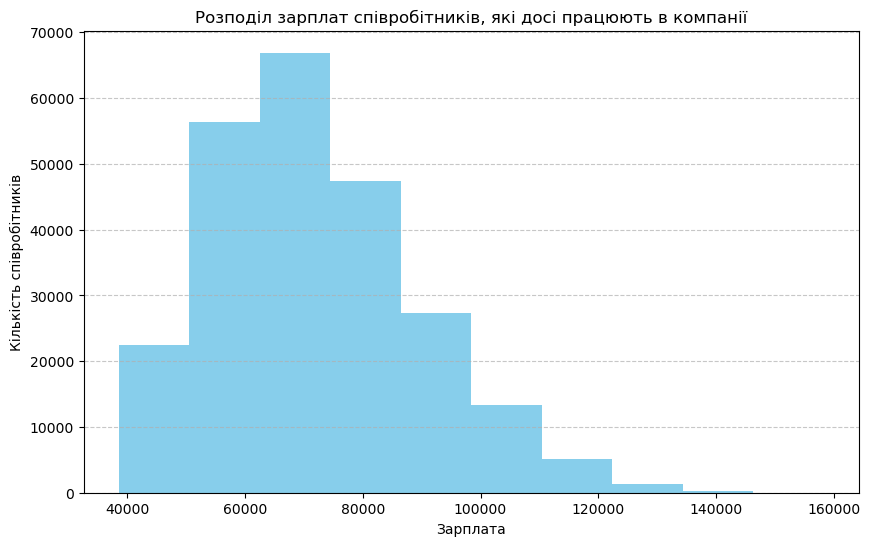

In [126]:
salary_still_employed = res.loc[still_employed, 'salary']

# Виведення гістограми
plt.figure(figsize=(10, 6))
plt.hist(salary_still_employed, bins=10, color='skyblue')
plt.title('Розподіл зарплат співробітників, які досі працюють в компанії')
plt.xlabel('Зарплата')
plt.ylabel('Кількість співробітників')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [128]:
cursor = con.cursor()

query = """
    SELECT hire_date, COUNT(*) as employee_count
    FROM employees
    GROUP BY hire_date
"""

# Використовуємо pandas.read_sql для виконання SQL-запиту та отримання результатів у DataFrame
df = pd.read_sql(query, con)

# Перетворюємо колонку hire_date в тип дати
df['hire_date'] = pd.to_datetime(df['hire_date'])

# Створюємо нову колонку з роком найму
df['hire_year'] = df['hire_date'].dt.year

# Групуєємо за роками та рахуємо кількість співробітників
df = df.groupby('hire_year')['employee_count'].sum().reset_index()

# Виводимо DataFrame
print(df)

# Закриваємо підключення
con.close()

C:\Users\User\AppData\Local\Temp\ipykernel_16248\2274801279.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


    hire_year  employee_count
0        1985           35316
1        1986           36150
2        1987           33501
3        1988           31436
4        1989           28394
5        1990           25610
6        1991           22568
7        1992           20402
8        1993           17772
9        1994           14835
10       1995           12115
11       1996            9574
12       1997            6669
13       1998            4155
14       1999            1514
15       2000              13


Очікуваний результат:

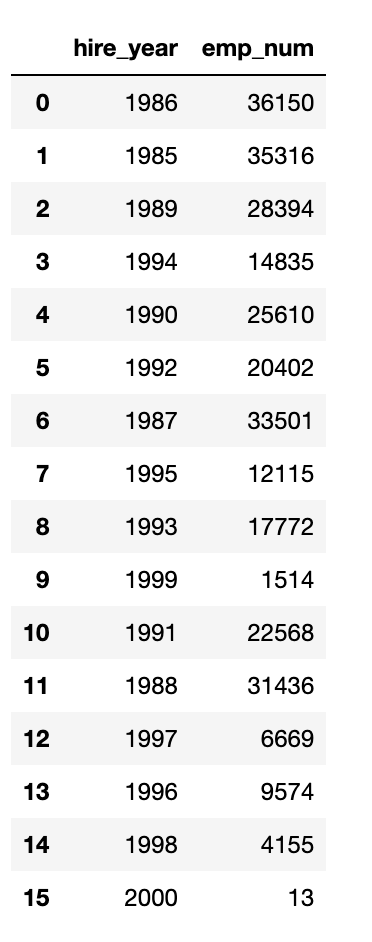

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

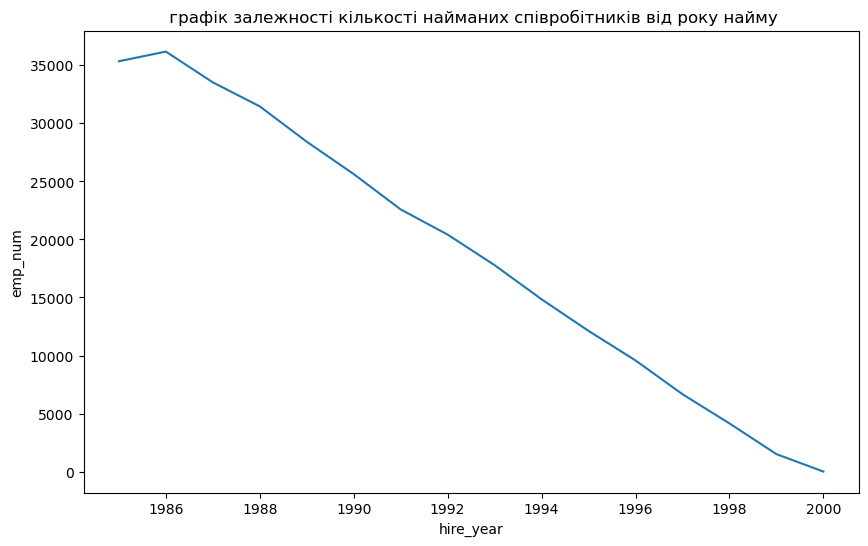

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(df['hire_year'], df['employee_count'])
plt.title(' графік залежності кількості найманих співробітників від року найму')
plt.xlabel('hire_year')
plt.ylabel('emp_num')
plt.show()

Очікуваний результат:

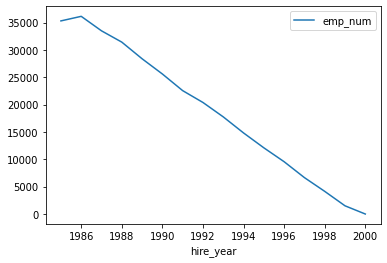

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [131]:
cursor = con.cursor()

query = """
    SELECT
        timestampdiff(YEAR, title.from_date, title.to_date) AS duration,
        title.from_date,
        title.to_date
    FROM
        employees emp
    JOIN
        titles title ON emp.emp_no = title.emp_no
    WHERE
        title.title = 'Engineer'
        AND title.to_date != '9999-01-01'
    """

df_years = pd.read_sql(query, con)

print(df_years)



C:\Users\User\AppData\Local\Temp\ipykernel_16248\1898055585.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_years = pd.read_sql(query, con)


       duration   from_date     to_date
0             9  1986-12-01  1995-12-01
1             5  1990-02-18  1995-02-18
2             8  1992-12-18  2000-12-18
3             8  1987-04-03  1995-04-03
4             5  1995-03-20  2001-03-19
...         ...         ...         ...
84015         9  1989-11-23  1998-11-23
84016         5  1989-07-30  1994-07-30
84017         0  1993-02-22  1993-10-27
84018         6  1996-05-13  2002-05-13
84019         4  1987-08-30  1992-08-29

[84020 rows x 3 columns]


Очікуваний результат:

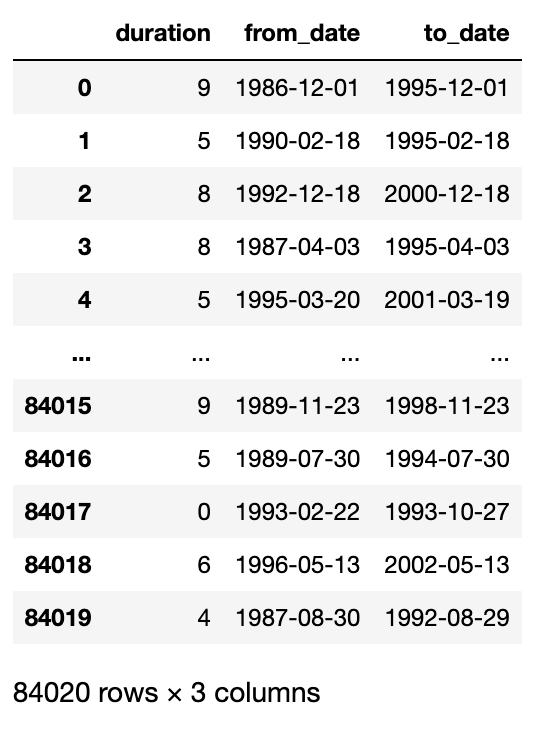

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

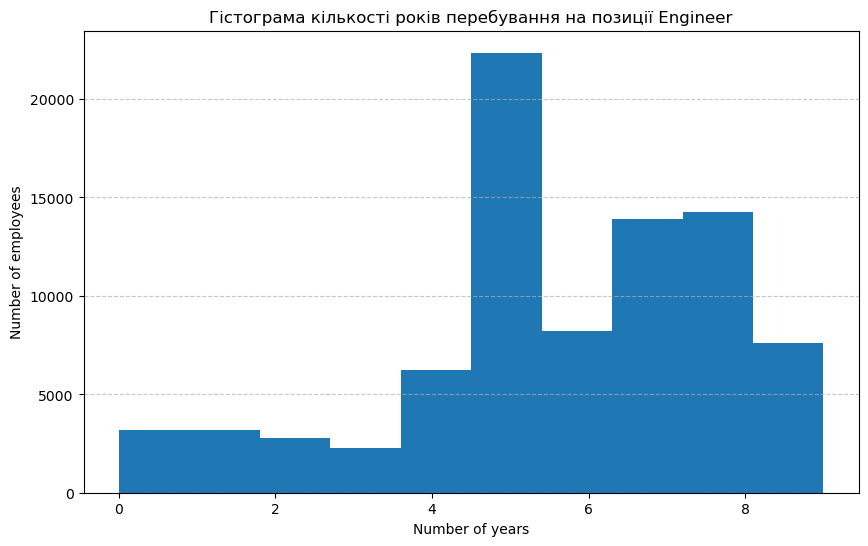

In [132]:
# Виведення гістограми
plt.figure(figsize=(10, 6))
plt.hist(df_years['duration'], bins=10)
plt.title('Гістограма кількості років перебування на позиції Engineer')
plt.xlabel('Number of years')
plt.ylabel('Number of employees')
plt.grid(axis='y', linestyle='--', alpha=0.7)

Очікуваний результат:

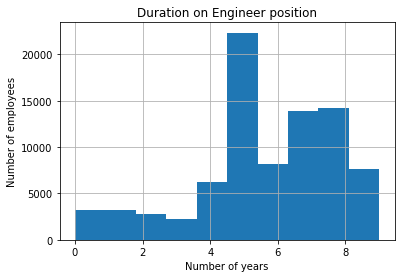

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [133]:
con.close()